# Train CNN_RNN

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_

from tqdm import tqdm

from utils.GloveMgr import GloveMgr
from utils.Dataset import Dataset
from utils.DataLoader import DataLoader
from utils.preprocess_df import preprocess_df
from utils.accuracy_nb_sent_per_doc import accuracy_nb_sent_per_doc_fn
from utils.accuracy_prop_sent_per_doc import accuracy_prop_sent_per_doc_fn

#from models.SIMPLE_CNN_RNN import SIMPLE_CNN_RNN

from time import time

import json
import argparse

In [2]:
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## (Hyper-)parameters

In [4]:
# Parse args if script mode
parser = argparse.ArgumentParser(description='extractive summary')

parser.add_argument('-is_graphic',type=int,default=1,choices=[0,1])
parser.add_argument('-gpu_num',type=int,default=1)
parser.add_argument('-batch_size',type=int,default=32)
parser.add_argument('-epochs',type=int,default=10)

args = None

if is_notebook():
    args = parser.parse_args("")
else:
    args = parser.parse_args()

In [5]:
# parameters
is_graphic = args.is_graphic != 0
cuda_num = args.gpu_num
embed_name = "glove.6B.100"

# hyper-parameters
vocab_size = 150000
batch_size = args.batch_size
epochs = args.epochs
learning_rate = 1e-3
model_name = "06-train_SIMPLE_CNN_RNN_without_text_content"
sub_folder_name = "model_name__{}__time__{}__embed_name__{}__lr__{}__batch_size__{}__vocab_size__{}__cuda_num__{}".format(model_name, time(), embed_name, learning_rate, batch_size, vocab_size, cuda_num)
checkpoints_folder = "./checkpoints/" + sub_folder_name
average_proportion_of_sentences_per_document = 0.2670278281534701
average_number_of_sentences_per_document = 6.061850780738518

# print
print("parse:")
print("is_graphic:", is_graphic)
print("cuda_num:", cuda_num)
print("epochs", epochs)
print("batch_size", batch_size)

parse:
is_graphic: True
cuda_num: 1
epochs 10
batch_size 32


## PyTorch initialisation

In [6]:
# Check if a GPU is available
if torch.cuda.is_available():
    # Display the number of available GPUs
    print(f"Number of available GPUs: {torch.cuda.device_count()}")
    # Display the name of each GPU
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available.")

Number of available GPUs: 7
GPU 0: NVIDIA GeForce GTX 1080 Ti
GPU 1: NVIDIA GeForce GTX 1080 Ti
GPU 2: NVIDIA GeForce GTX 1080 Ti
GPU 3: NVIDIA GeForce GTX 1080 Ti
GPU 4: NVIDIA GeForce GTX 1080
GPU 5: NVIDIA GeForce GTX 1080
GPU 6: NVIDIA GeForce GTX 1080


In [7]:
if torch.cuda.is_available():  
  dev = "cuda:" + str(cuda_num) 
else:  
  dev = "cpu" 

device = torch.device(dev)
device

device(type='cuda', index=1)

## Functions

In [8]:
def average(l):
    return sum(l) / len(l)

## Chargement des données

In [9]:
glovemgr = GloveMgr("./data/glove.6B/glove.6B.100d.txt", vocab_size=vocab_size)

In [10]:
train_dataset = Dataset(preprocess_df(pd.read_json("./data/train.json"), glovemgr=glovemgr, is_sep_n=True, remove_stop_word=True, stemming=False, trunc_sent=50, padding_sent=50, trunc_doc=100))
train_iter = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [11]:
val_dataset = Dataset(preprocess_df(pd.read_json("./data/val.json"), glovemgr=glovemgr, is_sep_n=True, remove_stop_word=True, stemming=False, trunc_sent=50, padding_sent=50, trunc_doc=100))
val_iter = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

## Model

In [12]:
from models.BasicModel import BasicModel
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class SIMPLE_CNN_RNN(BasicModel):
    def __init__(self, device, vocab_size, word_embed = None, dim_word_embed = 100):
        super(SIMPLE_CNN_RNN, self).__init__(device)

        self.device = device

        # 10: relative position range size, with segment size = 10
        self.rel_pos_emb = nn.Embedding(11, 100)
        self.abs_pos_emb = nn.Embedding(100, 100)

        self.Wabs_pos = nn.Linear(100,1,bias=False)
        self.Wrel_pos = nn.Linear(100,1,bias=False)
        self.bias = nn.Parameter(torch.empty(1).uniform_(-0.1, 0.1))

    def avg_pool1d(self,x,seq_lens):
        out = []
        for index,t in enumerate(x):
            if seq_lens[index] == 0:
                t = t[:1]
            else:
                t = t[:seq_lens[index],:]
            t = torch.t(t).unsqueeze(0)
            out.append(torch.avg_pool1d(t,t.size(2)))
        
        out = torch.cat(out).squeeze(2)
        return out

    def forward(self, arr_x, doc_lens):
        probs = []

        max_doc_lens = max(doc_lens)

        # Compute position embedding
        abs_poses = torch.tensor([[position] for position in range(max_doc_lens)], dtype=torch.long)
        abs_poses = abs_poses.to(self.device)
        abs_poses = self.abs_pos_emb(abs_poses).squeeze(1)
        aps = self.Wabs_pos(abs_poses)

        # Compute relative position embedding
        rel_poses = torch.tensor([[int(round(position / 10))] for position in range(max_doc_lens)], dtype=torch.long)
        rel_poses = rel_poses.to(self.device)
        rel_poses = self.rel_pos_emb(rel_poses).squeeze(1)
        rps = self.Wrel_pos(rel_poses)

        zeros = torch.zeros((len(doc_lens), 1)).to(self.device)

        # for each document, compute probabilities
        for position in range(max_doc_lens):
            prob = zeros + aps[position] + rps[position] + self.bias
            prob = torch.sigmoid(prob)
            probs.append(prob)

        probs = torch.cat(probs).squeeze()
        probs_filtered = []
        for idx, doc_len in enumerate(doc_lens):
            prob = probs[idx::len(doc_lens)]
            prob = prob[:doc_len]
            probs_filtered.append(prob)
        probs_filtered = torch.cat(probs_filtered).squeeze()
        #probs = probs.to(self.device)
        return probs_filtered


In [13]:
model = SIMPLE_CNN_RNN(device=device, vocab_size=vocab_size, word_embed=glovemgr.getEmbeddings())

In [14]:
model.to(device)

SIMPLE_CNN_RNN(
  (rel_pos_emb): Embedding(11, 100)
  (abs_pos_emb): Embedding(100, 100)
  (Wabs_pos): Linear(in_features=100, out_features=1, bias=False)
  (Wrel_pos): Linear(in_features=100, out_features=1, bias=False)
)

In [15]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adamax(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
mae_fn = nn.L1Loss()

## Train

In [16]:
if not os.path.exists(checkpoints_folder):
    os.makedirs(checkpoints_folder)

In [17]:
arr_train_loss = []
arr_train_mae = []
arr_train_acc = []
arr_val_loss = []
arr_val_mae = []
arr_val_acc = []

t1 = time()
for epoch in range(1, epochs+1):
    # train 1 epoch
    model.train()
    nb_batch_train = 0
    total_train_loss = 0
    total_train_mae = 0
    total_train_acc = 0
    with tqdm(train_iter, unit="batch", total=len(train_iter)) as tepoch:
        for batch in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            features = []
            doc_lens = []

            for j in range(batch_size):
                doc_lens.append(len(batch[j]["docs"]))
                features = features + batch[j]["docs"]
            
            features = torch.tensor(features, dtype=torch.long).to(device)

            targets = [torch.tensor(batch[j]["labels"], dtype=torch.float) for j in range(batch_size)]
            targets = torch.cat(targets)
            targets = targets.to(device)
            
            probs = model(features, doc_lens)
            
            loss = loss_fn(probs, targets)
            optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            nb_batch_train += 1
            total_train_loss += loss.item()
            total_train_mae += mae_fn(probs, targets).item()
            total_train_acc += accuracy_prop_sent_per_doc_fn(probs=probs.cpu().detach().numpy(), targets=targets.cpu().detach().numpy(), doc_lens=doc_lens)
            tepoch.set_postfix(loss=total_train_loss/nb_batch_train, mae=total_train_mae/nb_batch_train, accuracy=total_train_acc/nb_batch_train)
    # Save model
    model.save(checkpoints_folder + "/" + model_name + "-" + str(epoch) + ".pt")
    # Show train and val score
    model.eval()
    nb_batch_val = 0
    total_val_loss = 0
    total_val_mae = 0
    total_val_acc = 0
    for i,batch in enumerate(val_iter):
        features = []
        doc_lens = []

        for j in range(batch_size):
            doc_lens.append(len(batch[j]["docs"]))
            features = features + batch[j]["docs"]
            
        features = torch.tensor(features, dtype=torch.long).to(device)

        targets = [torch.tensor(batch[j]["labels"], dtype=torch.float) for j in range(batch_size)]
        targets = torch.cat(targets)
        targets = targets.to(device)
        
        probs = model(features, doc_lens)
        loss = loss_fn(probs, targets)
        nb_batch_val += 1
        total_val_loss += loss.item()
        total_val_mae += mae_fn(probs, targets).item()
        total_val_acc += accuracy_prop_sent_per_doc_fn(probs=probs.cpu().detach().numpy(), targets=targets.cpu().detach().numpy(), doc_lens=doc_lens)
    print("Epoch {} : train loss = {:.3f}, val loss = {:.3f}, train mae = {:.3f}, val mae = {:.3f}, train accuracy = {:.3f}, val accuracy = {:.3f}".format(epoch, total_train_loss / nb_batch_train, total_val_loss / nb_batch_val, total_train_mae / nb_batch_train, total_val_mae / nb_batch_val, total_train_acc / nb_batch_train, total_val_acc / nb_batch_val))

    arr_train_loss.append(total_train_loss / nb_batch_train)
    arr_train_mae.append(total_train_mae / nb_batch_train)
    arr_train_acc.append(total_train_acc / nb_batch_train)

    arr_val_loss.append(total_val_loss / nb_batch_val)
    arr_val_mae.append(total_val_mae / nb_batch_val)
    arr_val_acc.append(total_val_acc / nb_batch_val)

    # update lr
    scheduler.step()

t2 = time()
print("Training duration =", t2-t1)

Epoch 1: 100%|██████████| 6062/6062 [06:06<00:00, 16.53batch/s, accuracy=0.806, loss=0.379, mae=0.23] 


Epoch 1 : train loss = 0.379, val loss = 0.370, train mae = 0.230, val mae = 0.227, train accuracy = 0.806, val accuracy = 0.812


Epoch 2: 100%|██████████| 6062/6062 [06:10<00:00, 16.35batch/s, accuracy=0.806, loss=0.378, mae=0.229]


Epoch 2 : train loss = 0.378, val loss = 0.370, train mae = 0.229, val mae = 0.228, train accuracy = 0.806, val accuracy = 0.812


Epoch 3: 100%|██████████| 6062/6062 [06:02<00:00, 16.72batch/s, accuracy=0.807, loss=0.378, mae=0.229]


Epoch 3 : train loss = 0.378, val loss = 0.370, train mae = 0.229, val mae = 0.228, train accuracy = 0.807, val accuracy = 0.812


Epoch 4: 100%|██████████| 6062/6062 [06:06<00:00, 16.55batch/s, accuracy=0.807, loss=0.378, mae=0.229]


Epoch 4 : train loss = 0.378, val loss = 0.371, train mae = 0.229, val mae = 0.232, train accuracy = 0.807, val accuracy = 0.812


Epoch 5: 100%|██████████| 6062/6062 [06:05<00:00, 16.58batch/s, accuracy=0.807, loss=0.377, mae=0.229]


Epoch 5 : train loss = 0.377, val loss = 0.370, train mae = 0.229, val mae = 0.226, train accuracy = 0.807, val accuracy = 0.812


Epoch 6: 100%|██████████| 6062/6062 [06:09<00:00, 16.39batch/s, accuracy=0.807, loss=0.377, mae=0.229]


Epoch 6 : train loss = 0.377, val loss = 0.370, train mae = 0.229, val mae = 0.226, train accuracy = 0.807, val accuracy = 0.812


Epoch 7: 100%|██████████| 6062/6062 [06:07<00:00, 16.50batch/s, accuracy=0.807, loss=0.378, mae=0.229]


Epoch 7 : train loss = 0.378, val loss = 0.370, train mae = 0.229, val mae = 0.223, train accuracy = 0.807, val accuracy = 0.812


Epoch 8: 100%|██████████| 6062/6062 [06:11<00:00, 16.30batch/s, accuracy=0.807, loss=0.377, mae=0.229]


Epoch 8 : train loss = 0.377, val loss = 0.370, train mae = 0.229, val mae = 0.228, train accuracy = 0.807, val accuracy = 0.812


Epoch 9: 100%|██████████| 6062/6062 [06:09<00:00, 16.39batch/s, accuracy=0.807, loss=0.377, mae=0.229]


Epoch 9 : train loss = 0.377, val loss = 0.370, train mae = 0.229, val mae = 0.224, train accuracy = 0.807, val accuracy = 0.812


Epoch 10: 100%|██████████| 6062/6062 [06:08<00:00, 16.45batch/s, accuracy=0.807, loss=0.377, mae=0.229]


Epoch 10 : train loss = 0.377, val loss = 0.370, train mae = 0.229, val mae = 0.227, train accuracy = 0.807, val accuracy = 0.812
Training duration = 3797.8625440597534


In [18]:
training_metrics = {}
training_metrics["duration"]   = t2 - t1
training_metrics["train_loss"] = arr_train_loss
training_metrics["train_mae"]  = arr_train_mae
training_metrics["train_acc"]  = arr_train_acc
training_metrics["val_loss"]   = arr_val_loss
training_metrics["val_mae"]    = arr_val_mae
training_metrics["val_acc"]    = arr_val_acc

# Save to file in JSON format

with open(checkpoints_folder + "/training_metrics.json", 'w') as fp:
    json.dump(training_metrics, fp)

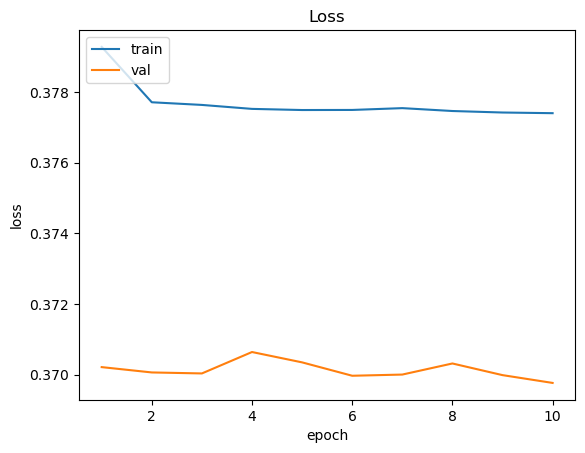

In [19]:
# draw Losses
if is_graphic:
    plt.plot(list(range(1, len(arr_train_loss) + 1)), arr_train_loss, label="train")
    plt.plot(list(range(1, len(arr_val_loss) + 1)), arr_val_loss, label="val")

    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(loc="upper left")

    plt.show()

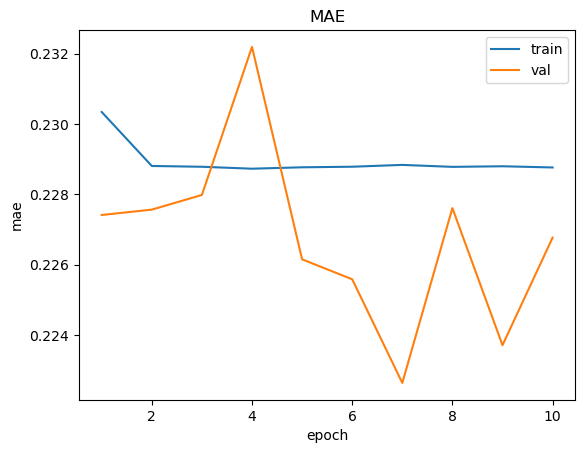

In [20]:
# draw mae
if is_graphic:
    plt.plot(list(range(1, len(arr_train_mae) + 1)), arr_train_mae, label="train")
    plt.plot(list(range(1, len(arr_val_mae) + 1)), arr_val_mae, label="val")

    plt.title("MAE")
    plt.xlabel("epoch")
    plt.ylabel("mae")
    plt.legend(loc="upper right")

    plt.show()

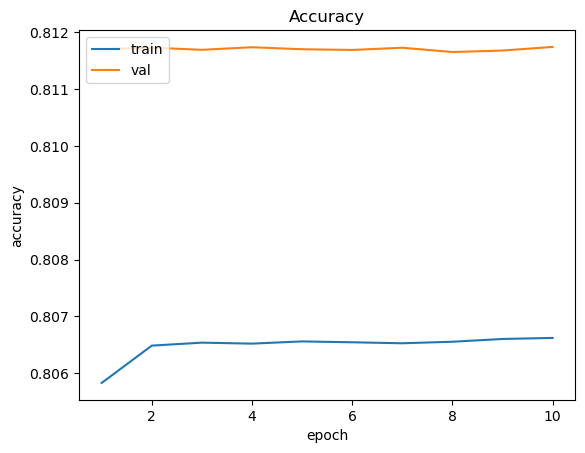

In [21]:
# draw Accuracies
if is_graphic:
    plt.plot(list(range(1, len(arr_train_acc) + 1)), arr_train_acc, label="train")
    plt.plot(list(range(1, len(arr_val_acc) + 1)), arr_val_acc, label="val")

    plt.title("Accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend(loc="upper left")

    plt.show()

# Eval model

In [22]:
from utils.split_all_docs import split_all_docs
from rouge_score import rouge_scorer
from utils.threshold_probs import threshold_probs_by_prop

In [23]:
model = SIMPLE_CNN_RNN(device=device, vocab_size=vocab_size, word_embed=glovemgr.getEmbeddings())

In [24]:
best_epoch = np.argmax(np.array(arr_val_acc)) + 1
model.load(checkpoints_folder + "/" + model_name + "-" + str(best_epoch) + ".pt")
model.to(device)
model.eval()

SIMPLE_CNN_RNN(
  (rel_pos_emb): Embedding(11, 100)
  (abs_pos_emb): Embedding(100, 100)
  (Wabs_pos): Linear(in_features=100, out_features=1, bias=False)
  (Wrel_pos): Linear(in_features=100, out_features=1, bias=False)
)

In [25]:
test_set = pd.read_json("./data/test.json")
test_set["doc_splited"] = split_all_docs(test_set["text"])

In [26]:
test_dataset = Dataset(preprocess_df(pd.read_json("./data/test.json"), glovemgr=glovemgr, is_sep_n=True, remove_stop_word=True, stemming=False, trunc_sent=50, padding_sent=50, trunc_doc=100))
test_iter = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

In [27]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
mae_fn = nn.L1Loss()

In [28]:
arr_rouge1 = []
arr_rouge2 = []
arr_rougeL = []
mae = []
accuracy = []

idx = 0
with tqdm(test_iter, unit="batch", total=len(test_iter)) as tepoch:
    for batch in tepoch:
        tepoch.set_description("Eval model")
        features = []
        doc_lens = []

        for j in range(1):
            doc_lens.append(len(batch[j]["docs"]))
            features = features + batch[j]["docs"]
                
        features = torch.tensor(features, dtype=torch.long).to(device)

        targets = [torch.tensor(batch[j]["labels"], dtype=torch.float) for j in range(1)]
        targets = torch.cat(targets)
        targets = targets.to(device)

        doc_empty = False
        for doc_len in doc_lens:
            if doc_len == 0 or doc_len == 1:
                doc_empty = True
        if not doc_empty:
            probs = model(features, doc_lens)

            doc = test_set["doc_splited"].iloc[idx]
            summaries = test_set["summaries"].iloc[idx]

            #probs = torch.tensor(threshold_probs_by_prop(probs=probs.cpu().detach().numpy(), doc_lens=[probs.shape[0]], average_proportion_of_sentences_per_document=average_proportion_of_sentences_per_document), dtype=torch.float).to(device)
            #txt = ""
                
            # print(len(doc), " ==", probs.shape)
            #for i in range(len(doc)):
            #    if probs[i] == 1:
            #        txt = txt + doc[i] + "."

            indices = torch.argsort(probs, descending=True)
            doc = np.array(doc)
            #nb_sent = int(len(doc) * average_proportion_of_sentences_per_document)
            txt = ""

            for i in range(min(len(doc), probs.shape[0])):
                txt = txt + ". " + doc[indices[i]]

            scores = scorer.score(summaries[:275], txt[:275])
            arr_rouge1.append(scores["rouge1"].recall)
            arr_rouge2.append(scores["rouge2"].recall)
            arr_rougeL.append(scores["rougeL"].recall)

            mae.append(mae_fn(probs, targets).item())

            accuracy.append(accuracy_prop_sent_per_doc_fn(probs=probs.cpu().detach().numpy(), targets=targets.cpu().detach().numpy(), doc_lens=doc_lens))
            tepoch.set_postfix(accuracy = average(accuracy), mae = average(mae), rouge1 = average(arr_rouge1), rouge2 = average(arr_rouge2), rougeL = average(arr_rougeL))
        idx += 1

Eval model: 100%|██████████| 10350/10350 [00:49<00:00, 209.73batch/s, accuracy=0.794, mae=0.262, rouge1=0.286, rouge2=0.146, rougeL=0.193]


In [29]:
test_metrics = {}
test_metrics["accuracy"] = average(accuracy)
test_metrics["mae"]      = average(mae)
test_metrics["rouge1"]   = average(arr_rouge1)
test_metrics["rouge2"]   = average(arr_rouge2)
test_metrics["rougeL"]   = average(arr_rougeL)

# Save to file in JSON format

with open(checkpoints_folder + "/test_metrics.json", 'w') as fp:
    json.dump(test_metrics, fp)

In [30]:
# Does not excute this cell if you want to execute the following cells.
import sys
sys.exit()

SystemExit: 

/home/raoufdine/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Others

In [1]:
import numpy as np
import json

In [2]:
# Mesurer la moyenne des resultats
dnames = ["model_name__SIMPLE_CNN_RNN__time__1681550854.9349496__embed_name__glove.6B.100__lr__0.001__batch_size__32__vocab_size__150000__cuda_num__0",\
          "model_name__SIMPLE_CNN_RNN__time__1681550881.4045916__embed_name__glove.6B.100__lr__0.001__batch_size__32__vocab_size__150000__cuda_num__1",\
          "model_name__SIMPLE_CNN_RNN__time__1681550891.4584005__embed_name__glove.6B.100__lr__0.001__batch_size__32__vocab_size__150000__cuda_num__2",\
          "model_name__SIMPLE_CNN_RNN__time__1681550899.8046584__embed_name__glove.6B.100__lr__0.001__batch_size__32__vocab_size__150000__cuda_num__3",\
          "model_name__SIMPLE_CNN_RNN__time__1681550906.110202__embed_name__glove.6B.100__lr__0.001__batch_size__32__vocab_size__150000__cuda_num__4",\
          "model_name__SIMPLE_CNN_RNN__time__1681550912.7112262__embed_name__glove.6B.100__lr__0.001__batch_size__32__vocab_size__150000__cuda_num__5",\
          "model_name__SIMPLE_CNN_RNN__time__1681550919.762202__embed_name__glove.6B.100__lr__0.001__batch_size__32__vocab_size__150000__cuda_num__6"]

In [3]:
# Temps d'exécution moyen
training_metrics = [json.load(open("./checkpoints/" + dname + "/training_metrics.json")) for dname in dnames]

durations = np.array([tm["duration"] for tm in training_metrics])

print("mean duration = {}+/-{}".format(np.mean(durations), np.std(durations)))

mean duration = 3841.5191779136658+/-100.59626224947613


In [4]:
# Scores
test_metrics = [json.load(open("./checkpoints/" + dname + "/test_metrics.json")) for dname in dnames]

accuracies = np.array([test_metrics[i]["accuracy"] for i in range(len(test_metrics))])
rouge1 = np.array([test_metrics[i]["rouge1"] for i in range(len(test_metrics))])
rouge2 = np.array([test_metrics[i]["rouge2"] for i in range(len(test_metrics))])
rougeL = np.array([test_metrics[i]["rougeL"] for i in range(len(test_metrics))])

print("accuracy = {}+/-{}".format(np.mean(accuracies), np.std(accuracies)))
print("rouge1 = {}+/-{}".format(np.mean(rouge1), np.std(rouge1)))
print("rouge2 = {}+/-{}".format(np.mean(rouge2), np.std(rouge2)))
print("rougeL = {}+/-{}".format(np.mean(rougeL), np.std(rougeL)))

accuracy = 0.7936516888331236+/-0.00016657131870246583
rouge1 = 0.3282220643254479+/-0.00010017259124904148
rouge2 = 0.16144588576483934+/-9.790878450587687e-05
rougeL = 0.2153257862839468+/-8.34819067998175e-05
